Computing Project - Monte carlo Simulation of fluids

In [162]:
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import re

In [163]:
#load config parameters
def load_jsonc(path):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()

    # remove // comments
    text = re.sub(r"//.*", "", text)
    # remove /* block comments */
    text = re.sub(r"/\\*.*?\\*/", "", text, flags=re.DOTALL)

    return json.loads(text)

config = load_jsonc("config.jsonc")
N   = config["N"]
L   = config["L"]
eta = config["eta"]


print(config)


{'N': 100, 'eta': 0.3, 'L': 100, 'dim': 2, 'equil_steps': 50000, 'prod_steps': 500000, 'sample_every': 1000, 'tune_every': 1000, 'r_max': 5.0, 'gr_bins': 200, 'lattice': 'square', 'seed': 12345}


In [164]:
#Computing box size from N, density, and particle diameter. Maximum particle diameter of 1? Why not define box as sqrt(N)?
def sigma_from_eta_2d(N: int, L: float, eta: float) -> float:
    """
    From 2D packing fraction:
      eta = N * (pi * sigma^2 / 4) / L^2
      -> sigma = 2 L sqrt(eta / (N pi))
    """
    return 2.0 * L * math.sqrt(eta / (N * math.pi))

In [165]:
def balanced_grid_shape_2d(N: int) -> tuple[int, int]:
    """
    Choose an integer grid (nx, ny) with nx*ny >= N and as close to square as possible.
    """
    n = math.ceil(math.sqrt(N))
    return n, n  # simple and near-optimal for most N

In [166]:
def square_lattice_positions_2d(N: int, L: float) -> tuple[np.ndarray, tuple[float, float]]:
    """
    Return (N, 2) positions on a square grid, cell-centered so all disks lie fully inside [0, L]^2.
    Also return the spacings (ax, ay) between neighboring centers.
    """
    nx, ny = balanced_grid_shape_2d(N)
    ax, ay = L / nx, L / ny
    coords = []
    for j in range(ny):
        y = (j + 0.5) * ay
        for i in range(nx):
            x = (i + 0.5) * ax
            coords.append((x, y))
    return np.array(coords[:N], dtype=float), (ax, ay)

In [167]:
def initialize_cubic_lattice_2d(N: int, L: float, eta: float):
    """
    Initialize N particles on a 2D cubic (square) lattice in a fixed box of side L.
    Particle diameter sigma is determined by the packing fraction eta.
    Ensures no overlaps (spacing >= sigma). Returns (positions, sigma, eta_actual, (ax, ay)).
    """
    # 1) derive particle size from (N, L, eta)
    sigma = sigma_from_eta_2d(N, L, eta)

    # 2) place on a cell-centered square grid
    positions, (ax, ay) = square_lattice_positions_2d(N, L)

    # 3) feasibility: minimal center spacing must be >= sigma
    a_min = min(ax, ay)
    if a_min < sigma - 1e-12:
        # Maximum feasible eta with this grid (touching, sigma=a_min):
        eta_max_touching = (N * math.pi * (a_min**2) / 4.0) / (L**2)
        raise ValueError(
            f"Infeasible: target η={eta:.6g} ⇒ σ={sigma:.6g}, but grid spacing a_min={a_min:.6g} < σ (overlap).\n"
            f"Lower η to ≤ ~{eta_max_touching:.6g}, increase L, or reduce N."
        )

    # 4) actual eta (equals requested eta by construction)
    eta_actual = (N * math.pi * sigma**2 / 4.0) / (L**2)
    return positions, sigma, eta_actual, (ax, ay)

In [168]:
positions, sigma, eta_actual, spacings = initialize_cubic_lattice_2d(N, L, eta)

In [169]:
print("Loaded from config:")
print(f"N   = {N}")
print(f"L   = {L}")
print(f"eta = {eta}")

print("\nComputed:")
print(f"sigma = {sigma}")
print(f"actual packing = {eta_actual}")
print(f"grid spacing = {spacings}")

print("\nFirst 5 particles:\n", positions[:5])

Loaded from config:
N   = 100
L   = 100
eta = 0.3

Computed:
sigma = 6.180387232371033
actual packing = 0.29999999999999993
grid spacing = (10.0, 10.0)

First 5 particles:
 [[ 5.  5.]
 [15.  5.]
 [25.  5.]
 [35.  5.]
 [45.  5.]]


In [170]:
def plot_disks_LxL(positions: np.ndarray, L: float, sigma: float, title: str = ""):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect("equal")
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_position([0, 0, 1, 1])  # remove all margins
    if title:
        ax.set_title(title, pad=8)

    # draw disks fully inside box
    r = sigma / 2.0
    for (x, y) in positions:
        ax.add_patch(plt.Circle((x, y), r, fc="navy", ec="black", lw=0.6))

    # box outline
    ax.plot([0, L, L, 0, 0], [0, 0, L, L, 0], "k-", lw=1)
    plt.show()

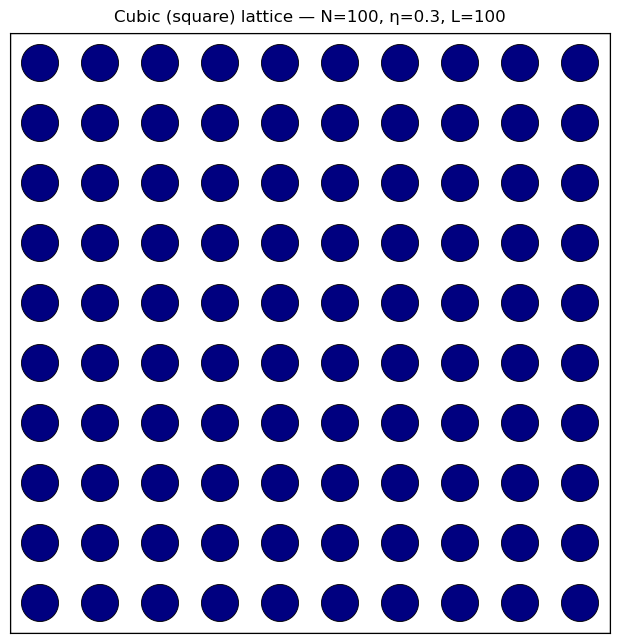

In [171]:
plot_disks_LxL(
        positions,
        L,
        sigma,
        title=f"Cubic (square) lattice — N={N}, η={eta}, L={L}"
    )

In [172]:
def random_jiggle(positions, max_step, seed=None):
    """
    Return a new array where each particle is displaced by a random vector
    with components in [-max_step, +max_step]. No boundary handling.
    """
    rng = np.random.default_rng(seed)
    disp = rng.uniform(-max_step, max_step, size=positions.shape)
    return positions + disp
print("John Pork kissed a sheep")

John Pork kissed a sheep


In [173]:
def plot_disks_LxL(positions, L, sigma, title=""):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect("equal")
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_position([0, 0, 1, 1])
    if title: ax.set_title(title, pad=8)
    r = sigma / 2.0
    for (x, y) in positions:
        ax.add_patch(plt.Circle((x, y), r, fc="navy", ec="white", lw=0.6))
    ax.plot([0, L, L, 0, 0], [0, 0, L, L, 0], "k-", lw=1)
    plt.show()

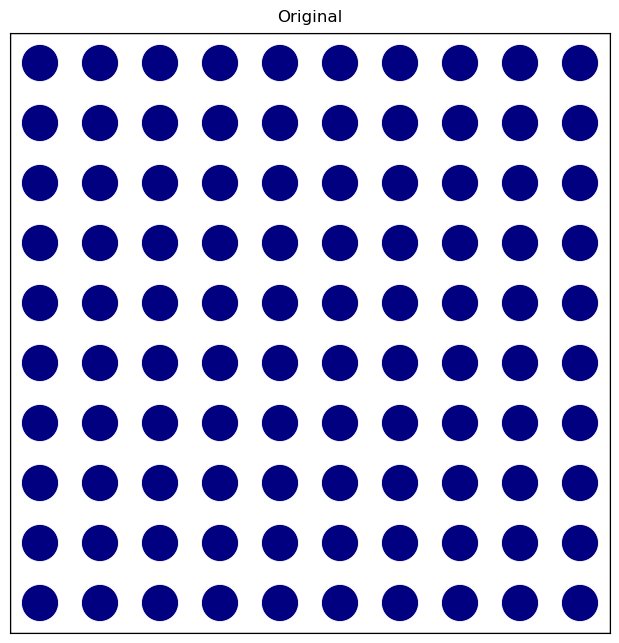

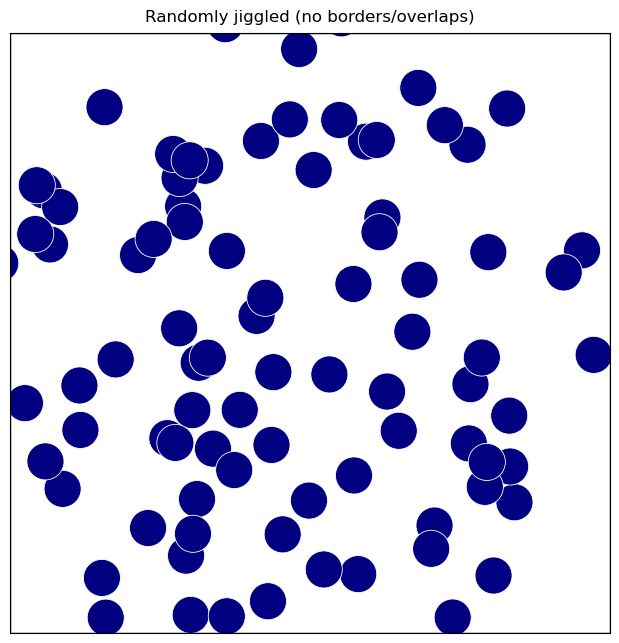

In [174]:
max_step = 2 * min(spacings)   # e.g., 10% of grid spacing (nice small jiggle)
new_positions = random_jiggle(positions, max_step, seed=42)

plot_disks_LxL(positions, L, sigma, title="Original")
plot_disks_LxL(new_positions, L, sigma, title="Randomly jiggled (no borders/overlaps)")

In [175]:
def wrap_positions(positions: np.ndarray, L: float) -> np.ndarray:
    """
    Map every coordinate into [0, L) using periodic boundaries.
    positions: (N, 2) float array
    """
    return positions % L

def wrap_single(pos: np.ndarray, L: float) -> np.ndarray:
    """Wrap a single 2D position into [0, L)."""
    return pos % L


In [176]:
def minimum_image_displacement(d: np.ndarray, L: float) -> np.ndarray:
    """
    Apply MIC to a displacement vector d (2D).
    For each component: d <- d - L * round(d / L)
    """
    return d - L * np.round(d / L)

def pair_distance_mic(p_i: np.ndarray, p_j: np.ndarray, L: float) -> float:
    """
    Minimum-image distance between two 2D points under PBC.
    """
    d = p_i - p_j
    d = minimum_image_displacement(d, L)
    return float(np.sqrt(np.dot(d, d)))

In [177]:
def random_jiggle_wrapped(positions: np.ndarray, max_step: float, L: float, seed=None) -> np.ndarray:
    """
    Displace EVERY particle by a random vector in [-max_step, +max_step] per axis,
    then wrap into [0, L). (No overlap/border checks.)
    """
    rng = np.random.default_rng(seed)
    disp = rng.uniform(-max_step, max_step, size=positions.shape)
    return wrap_positions(positions + disp, L)

def attempt_single_particle_move_wrapped(
    positions: np.ndarray, i: int, step: float, L: float, rng: np.random.Generator
) -> np.ndarray:
    """
    Move ONE particle i by a random displacement in [-step, +step] (per axis),
    wrap it, and return the UPDATED positions array. (No acceptance test here.)
    """
    new_positions = positions.copy()
    delta = rng.uniform(-step, step, size=2)
    new_positions[i] = wrap_single(new_positions[i] + delta, L)
    return new_positions

In [178]:
def demo_move_all(positions: np.ndarray, L: float, sigma: float, max_step: float, plot_fn=None):
    """
    Jiggle all particles with wrapping and optionally plot.
    """
    new_pos = random_jiggle_wrapped(positions, max_step=max_step, L=L, seed=42)
    if plot_fn is not None:
        plot_fn(positions, L, sigma, title="Original")
        plot_fn(new_pos, L, sigma, title="Jiggled (wrapped)")
    return new_pos

def demo_min_distance(positions: np.ndarray, L: float) -> float:
    """
    Compute the minimum pair distance using MIC (handy sanity check).
    """
    N = positions.shape[0]
    rmin = np.inf
    for i in range(N - 1):
        d = positions[i] - positions[i+1:]
        d = d - L * np.round(d / L)
        rij = np.sqrt(np.sum(d * d, axis=1))
        rmin = min(rmin, float(np.min(rij)))
    return rmin

In [179]:
def plot_disks_LxL(pos, L, sigma, title=""):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect("equal"); ax.set_xlim(0,L); ax.set_ylim(0,L)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_position([0,0,1,1])
    for (x,y) in pos:
        ax.add_patch(plt.Circle((x,y), sigma/2, fc="navy", ec="white", lw=0.6))
    ax.plot([0,L,L,0,0],[0,0,L,L,0],"k-",lw=1)
    if title: ax.set_title(title, pad=8)
    plt.show()

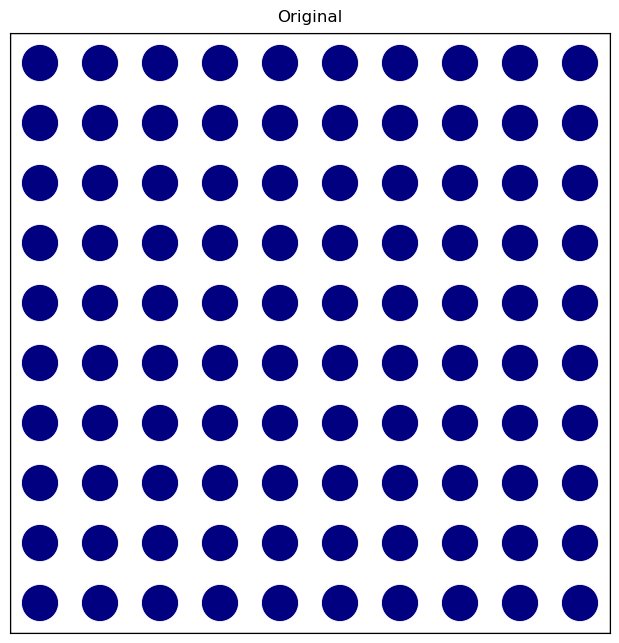

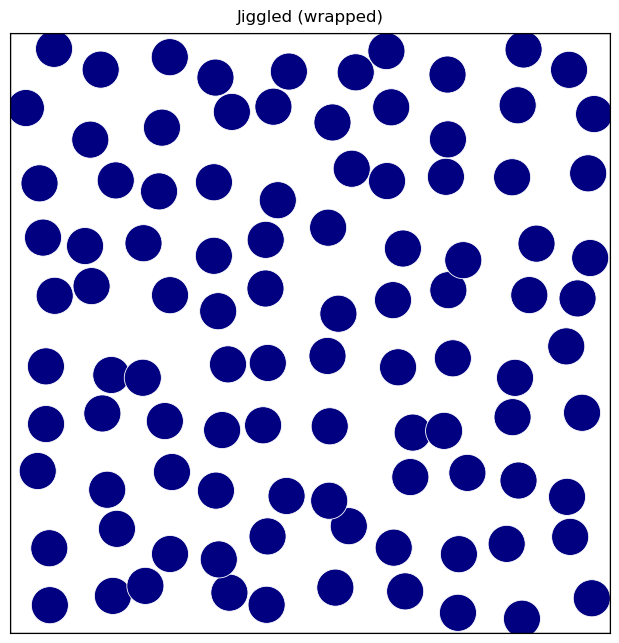

min MIC distance = 0.09541481107126239


In [180]:
# Jiggle all with wrapping
positions = demo_move_all(positions, L, sigma, max_step=3, plot_fn=plot_disks_LxL)

# Or move a single random particle
rng = np.random.default_rng(0)
i = rng.integers(0, len(positions))
positions = random_jiggle_wrapped(positions, max_step=max_step, L=L, seed=42)


# Sanity: check MIC min distance
print("min MIC distance =", demo_min_distance(positions, L))